Input dataset:
- training_data_exo.csv

This notebook includes:
- Test for significance and FDR
- Feature correlation
- Violin plots (continuous features)
- PCA

# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy.stats import mannwhitneyu, fisher_exact
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import fdrcorrection

%matplotlib inline

# Define paths

In [2]:
Data_path = os.path.dirname(os.path.dirname(os.getcwd())) + '/Data'

# Import dataset

### Feature dataset (Exosomes)

In [3]:
df = Data_path + '/MachineLearning/training_data_exo.csv' 
df_exo = pd.read_csv(df, sep=',', engine='python')

In [4]:
df_exo

,id,length,hydr_count,polar_count,molecular_weight,helix,turn,sheet,A,C,...,coiled_coil,EGF,RAS_profile,RRM,ww_domain,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,Exosome
0,Q92667,9.818582,0.376523,0.370986,16.793404,0.079734,0.805094,0.115172,0.079734,0.018826,...,1,0,0,0,0,1,1,0.447738,0.263651,0
1,P62736,8.558421,0.427056,0.379310,15.574035,0.445623,0.347480,0.206897,0.076923,0.018568,...,0,0,0,0,0,0,0,0.682540,0.111111,1
2,Q9H553,8.700440,0.471154,0.358173,15.735720,0.485577,0.375000,0.139423,0.072115,0.028846,...,0,0,0,0,0,1,0,0.614286,0.185714,0
3,P0C7M7,9.179909,0.424138,0.379310,16.216178,0.320690,0.448276,0.231034,0.058621,0.022414,...,0,0,0,0,0,0,0,0.661111,0.088889,0
4,P49703,7.651052,0.417910,0.402985,14.652697,0.328358,0.477612,0.194030,0.099502,0.004975,...,0,0,0,0,0,0,0,0.567010,0.195876,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12791,Q9Y6F7,9.079485,0.386322,0.454713,16.100194,0.280961,0.595194,0.123845,0.075786,0.020333,...,0,0,0,0,0,0,0,0.588757,0.242604,0
12792,P26368,8.891784,0.366316,0.429474,15.920828,0.178947,0.604211,0.216842,0.056842,0.012632,...,0,0,0,1,0,0,0,0.621849,0.130252,1
12793,Q9BTX3,7.434628,0.514451,0.306358,14.472938,0.624277,0.352601,0.023121,0.104046,0.011561,...,0,0,0,0,0,1,1,0.460674,0.382022,0
12794,A6NFC5,7.800900,0.560538,0.179372,14.739747,0.573991,0.300448,0.125561,0.121076,0.031390,...,0,0,0,0,0,1,1,0.310000,0.420000,0


In [5]:
Exo_yes = df_exo[df_exo["Exosome"] == 1]
Exo_no = df_exo[df_exo["Exosome"] == 0]

# Feature analysis

In [6]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed']

features_categorical = ['HSP', 'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP',
       'Lipoprotein_UP', 'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all', 'Nitrosylation_all',
       'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all',
       'Ubiquitination_all', 'PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD',
       'coiled_coil', 'RAS_profile', 'ww_domain', 'EGF', 'RRM', 'transmembrane', 'TMHMM']

### Mann-Whitney U Test

In [7]:
# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    
    stat, p = mannwhitneyu(Exo_yes[feature], Exo_no[feature]) # function returns statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

In [8]:
# save both p-values in dataframe
p_vals_comb = pd.concat([p_vals, p_vals_adj], axis=1)
# sort by adjusted p-value
p_vals_comb = p_vals_comb.sort_values(by='p_value_adjusted')

In [9]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb)):
    print(p_vals_comb.index[i], 'p=%.5f' % (p_vals_comb.p_value_adjusted[i]))

D_exposed p=0.00000
L_exposed p=0.00000
length p=0.00000
molecular_weight p=0.00000
Hydrophobic_exposed p=0.00000
Instability_index p=0.00000
rhsa_netsurfp2 p=0.00000
Polar_exposed p=0.00000
D p=0.00000
charge_at_7 p=0.00000
isoelectric_point p=0.00000
E_exposed p=0.00000
sheet p=0.00000
C_exposed p=0.00000
W_exposed p=0.00000
tasa_netsurfp2 p=0.00000
H p=0.00000
turn p=0.00000
N_exposed p=0.00000
C p=0.00000
S p=0.00000
K_exposed p=0.00000
disorder p=0.00000
I p=0.00000
F_exposed p=0.00000
V p=0.00000
N p=0.00000
H_exposed p=0.00000
P p=0.00000
W p=0.00000
V_exposed p=0.00000
S_exposed p=0.00000
thsa_netsurfp2 p=0.00000
Prob. of Solubility p=0.00000
R p=0.00000
Y_exposed p=0.00000
G p=0.00000
I_exposed p=0.00000
K p=0.00000
R_exposed p=0.00000
Aggregation_propensity p=0.00000
L p=0.00000
P_exposed p=0.00000
M_exposed p=0.00000
polar_count p=0.00000
A p=0.00000
G_exposed p=0.00000
E p=0.00000
Q_exposed p=0.00000
M p=0.00000
T p=0.00000
Y p=0.00001
helix p=0.00062
Aromaticity p=0.00097


### Fisher's exact test	

In [10]:
# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(Exo_yes[feature]) # EV & positive
    B = len(Exo_yes[feature]) - sum(Exo_yes[feature]) # EV & negative
    C = sum(Exo_no[feature]) # no EV & positive
    D = len(Exo_no[feature]) - sum(Exo_no[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function returns odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')

In [11]:
# save both p-values in dataframe
p_vals_comb_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)
# sort by adjusted p-value
p_vals_comb_cat = p_vals_comb_cat.sort_values(by='p_value_adjusted')

In [12]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb_cat)):
    print(p_vals_comb_cat.index[i], 'p=%.5f' % (p_vals_comb_cat.p_value_adjusted[i]))

Palmitoylation_all p=0.00000
PTM_UP p=0.00000
Acetylation_all p=0.00000
Methylation_all p=0.00000
Ubiquitination_all p=0.00000
Nitrosylation_all p=0.00000
Acetylation_MSD p=0.00000
Phosphorylation_all p=0.00000
SUMOylation_MSD p=0.00000
SUMOylation_all p=0.00000
Ubiquitination_MSD p=0.00000
Glycosylation_MSD p=0.00000
Glycosylation_all p=0.00000
coiled_coil p=0.00000
Lipoprotein_UP p=0.00000
Methylation_MSD p=0.00000
EGF p=0.00000
Prenylation_UP p=0.00000
RRM p=0.00000
Phosphorylation_MSD p=0.00000
RAS_profile p=0.00000
ISGylation_UP p=0.00000
PTM_MSD p=0.00000
HSP p=0.00000
TMHMM p=0.00000
Nitration_UP p=0.00000
Citrullination_UP p=0.00000
Myristoylation_all p=0.00003
ww_domain p=0.00330
GPI-anchor_UP p=0.05338
transmembrane p=0.20236
NEDDylation_UP p=0.32903
Palmitoylation_MSD p=0.69381


### Feature correlation

In [13]:
# calculate pairwise correlation
corr_exo = df_exo.corr()

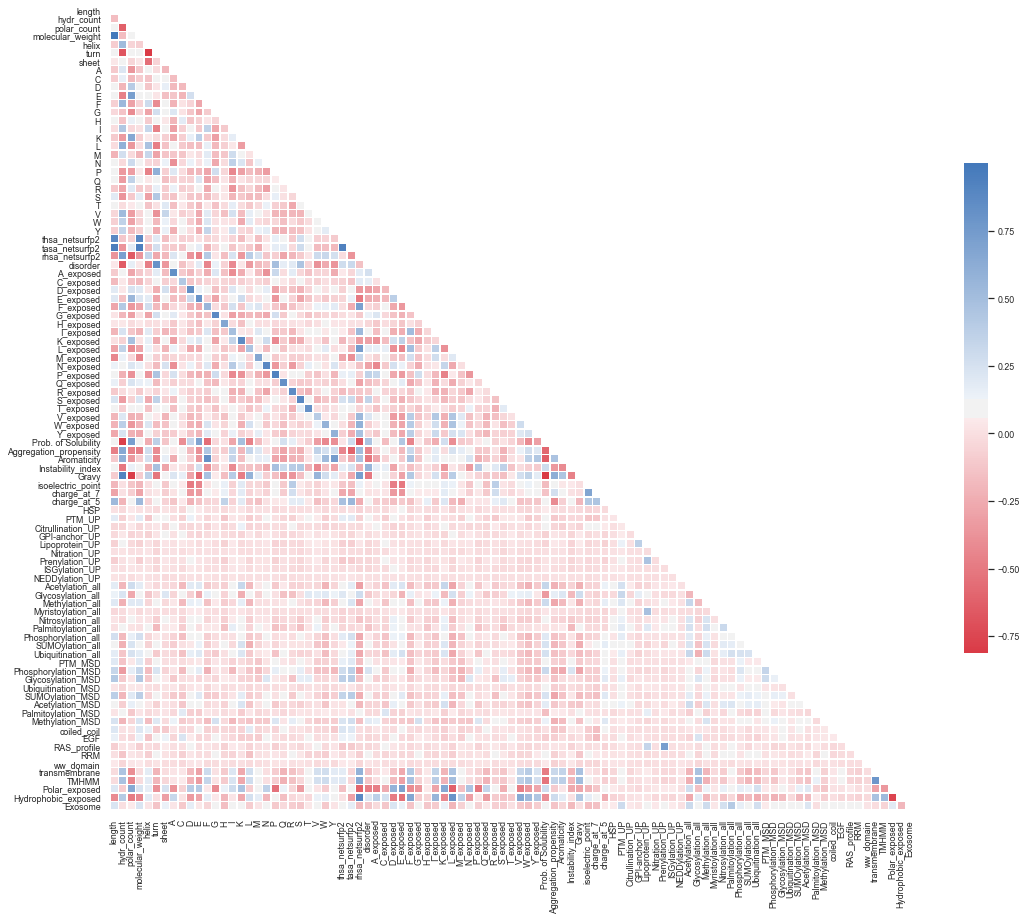

In [14]:
# figure settings
sns.set(font_scale=0.8)

mask = np.triu(np.ones_like(corr_exo, dtype=bool))
sns.set_style(style = 'white')
fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_exo, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True);

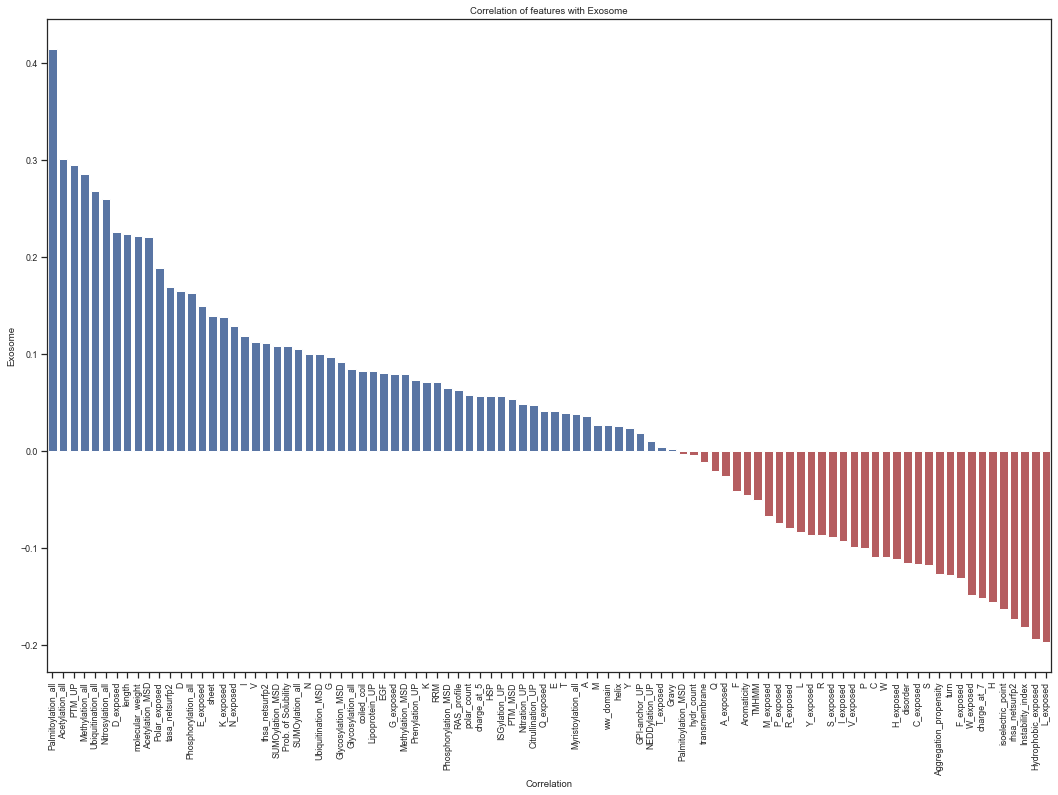

In [15]:
# figure settings
sns.set(style=("ticks"), font_scale=0.8)

correlations_exo = corr_exo[['Exosome']].sort_values(by="Exosome", ascending=False)[1:]
correlations_exo.reset_index(inplace=True)

colors_exo = ["b" if (x > 0) else "r" for x in correlations_exo["Exosome"]]

fig = plt.figure(figsize=(18, 12)) 
sns.barplot(x="index", y="Exosome", data=correlations_exo, palette=colors_exo)
plt.xlabel("Features") 
plt.xticks(rotation=90)
plt.xlabel("Correlation")
plt.title("Correlation of features with Exosome");

### Violin plots

In [16]:
sns.set(style=("ticks"), font_scale=1.2)
x1, x2 = 0, 1 
my_pal = {1: "palevioletred", 0: "darkred"}
dataset = df_exo
labels = ["Exosome", "non-Exosome"]

#### Physicochemical features

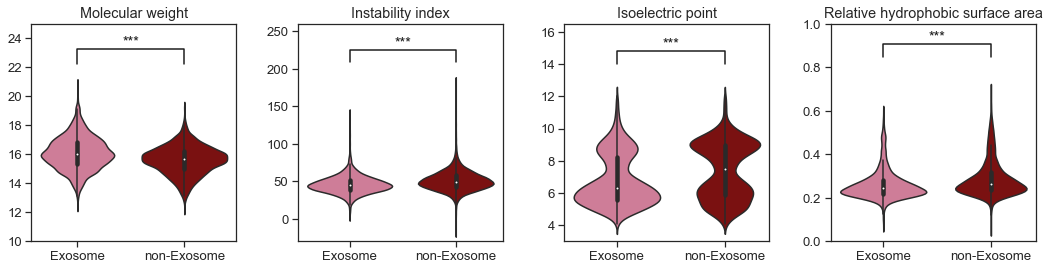

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(18, 4))

sns.violinplot(x=labels[0], y='molecular_weight', data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Molecular weight", xticklabels=(labels), ylim=(10, 25))
y, h, col = dataset['molecular_weight'].max() + 1.5, 1, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='Instability_index', data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels), ylim=(-30, 260))
y, h, col = dataset['Instability_index'].max() + 25, 15, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='isoelectric_point', data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Isoelectric point", xticklabels=(labels), ylim=(3, 16.5))
y, h, col = dataset['isoelectric_point'].max() + 2, 0.8, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='rhsa_netsurfp2', data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Relative hydrophobic surface area", xticklabels=(labels), ylim=(0, 1))
y, h, col = dataset['rhsa_netsurfp2'].max() + 0.15, 0.06, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.subplots_adjust(wspace = 0.3)
plt.show()

#### Structural features

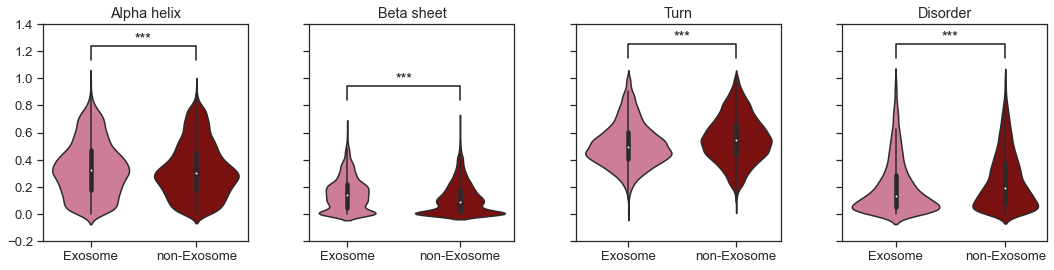

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(18, 4))
plt.ylim((-0.2, 1.4))

sns.violinplot(x=labels[0], y='helix', data=dataset, ax=ax1, order=[1, 0], palette=my_pal)
ax1.set(ylabel=None, xlabel=None, title="Alpha helix", xticklabels=(labels))
y, h, col = dataset['helix'].max() + 0.15, 0.1, 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax1.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='sheet', data=dataset, ax=ax2, order=[1, 0], palette=my_pal)
ax2.set(ylabel=None, xlabel=None, title="Beta sheet", xticklabels=(labels))
y, h, col = dataset['sheet'].max() + 0.15, 0.1, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='turn', data=dataset, ax=ax3, order=[1, 0], palette=my_pal)
ax3.set(ylabel=None, xlabel=None, title="Turn", xticklabels=(labels))
y, h, col = dataset['turn'].max() + 0.15, 0.1, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x=labels[0], y='disorder', data=dataset, ax=ax4, order=[1, 0], palette=my_pal)
ax4.set(ylabel=None, xlabel=None, title="Disorder", xticklabels=(labels))
y, h, col = dataset['disorder'].max() + 0.15, 0.1, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

plt.subplots_adjust(wspace = 0.3)
plt.show()